Author: Josh Kuppersmith

Date: December 9, 2018

Subject: Modeling Notebook, Clustering and Predictions

Advisor: Pavlos Protopapas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sklearn
from operator import add
import csv 
import gmaps
import overpy
import math
import geoplotlib
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import warnings
import geopandas
from geopandas.tools import sjoin
from matplotlib.patches import Polygon
from shapely.geometry import shape, Point
import shapely
import fiona

import xgboost as xgb
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# note: learn more about EMD and how to use it
from pyemd import emd
from pyemd import emd_samples

pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
plt.style.use('seaborn')

#### Introduction/Notebook Description: 

In this notebook, we complete both baseline and project models. These are clustering models. A key piece of this is the metric by which we measure success of clustering. For this we use earth moving distance to measure tightness of cluster, which is focused on crime profiles across cells in a given neighborhood. Where the magic happens! 

#### Running Instructions: 

Run like normal. First section will load the data from our pre-processing and EDA, then the rest runs models, with bolded headers between each so that we can run them separately if we want. 

#### Key Concepts

##### Clustering - K-Means, New Geographic Algo, Etc.:

I need to write a new clustering algorithm that uses a different distance metric than euclidean distance. This is for two reasons. First, rather than considering difference in latitude and difference in longitude for clustering, we must consider the haversine distance between coordinate sets because this takes into account the fact that Chicago is not on the equator, so equivalent offsets in latitude and longitude do not represent the same spatial distance. Additionally, all of our clustering measures must emphasize neighboring cells being clustered together. Intuitively, it does not make sense to have a neighborhood that contains cells all across the city, so we must ensure close geographic distance is the most important factor. For that reason, when we define the new distance function for clustering (which we will try to minimize in k-means clustering), it must be something like [10 * (cell haversine distance) + 1 * (euclidean vector distance of other metrics)] in order to weight geographic distance as the most important, and let the other factors be a sort of "tie breaker". We probably need a better way to determine the weighting here, but this seems to be the general structure of this 'weighted geographic clustering' method. 

##### Poisson Regression and Gradient Boosting:

Not really relevant. This is the method that we use for the cross city crime regression, but that's not really the goal of this project. Come back to this if it seems to be a good approach for any of my goals. 

##### Network Clustering and Gravitational Wrapping:

Gravitational wrapping does not seem to be very relevant, but there is a paper "Gravitational Clustering" by Wright that could give us a good way to perform a weighted clustering measure that gravitationally pulls cells towards central hubs, or areas with high densities of transportation locations. Also, with respect to network clustering, there are a lot of different algorithms that I can use, and most are well written and documented in several python libraries and wrappers. WCA and SCAN seem to be good algorithms to do this. For now, network clustering is probably the most experimental approach, so no need to go into too much detail about choosing a clustering algorithm with no guarantee of the viability of this approach. The most challenging part here will be to find a way to represent the city as a weighted transportation network, taking into account distance in many senses, so this is a work in progress. In this case, cells will be nodes and transportation possibilities edges, and it shouldn't be impossible, but there will be many challenges. The good thing about the weighted network representation is that I don't really need to take into account two step transportation because our network clustering algorithms should pick central nodes and cluster them with those that are nearby. 

##### Earth Moving Distance and Other Success Metrics:

The simple metric for tightness of clusters that we can use is to represent crime profiles as a vector (i.e. ['Total Crime', 'Theft', 'Battery', 'Narcotics', 'Assault', ...] using the most significant crime metrics (or all of them, TBD and need to decide on this), and then calculate the average crime profile vector for a cluster (or neighborhood), and then calculate the mean absolute error, which is the mean euclidean distance between crime vectors for individual cells and the average profile vector. This is the simple tightness metric.

Another metric that we will use in the average Earth Mover's Distance, which has become a popular way of calculating distances. Essentially, in this framework, each crime profile vector represents a crime distribution, and between any two cells (or between a cell and the mean crime profile vector for a neighborhood), and we can calculate this with pyemd, which is a python wrapper for a C++ Earth Mover's Distance package. We can either define our own distance field, or (as we will do here), just calculate a sample distance between distributions. Our internal variance metric will be the average of the EMDs between the average and the crime profile distribution for each cell. 

Another thought, maybe we should represent the distribution as a vector of all of the number for (for example) assault, so we have several distributions for each neighborhood rather than one distribution per cell? It's an idea but not sure how it would be put to use. 



In [2]:
# Load in all cleaned datasets
crime = pd.read_csv("Cleaned/CHI_ALL_Cleaned.csv")
osm = pd.read_csv("Cleaned/CHI_OSM_Cleaned.csv")
cell_towers = pd.read_csv("Cleaned/CHI_Cells_Cleaned.csv")
divvy = pd.read_csv("Cleaned/DIVVY_STATIONS_Cleaned.csv")
tranportation = pd.read_csv("Cleaned/OSM_Transportation_Cleaned.csv")
bikes = pd.read_csv("Cleaned/Bike_Racks_Cleaned.csv")
bus_stops = pd.read_csv("Cleaned/CTA_Bus_Stops_Cleaned.csv")
l_stops = pd.read_csv("Cleaned/L_STOPS_Cleaned.csv")
metra = pd.read_csv("Cleaned/METRA_Cleaned.csv")
transportation_agg = pd.read_csv("Cleaned/Transportation.csv")

In [3]:
# shapefile data
streets = geopandas.read_file("Cleaned/Major_Streets_Cleaned.shp")
bus_routes = geopandas.read_file("Cleaned/Bus_Routes_Cleaned.shp")
bike_paths = geopandas.read_file("Cleaned/Bike_Cleaned.shp")
l_lines = geopandas.read_file("Cleaned/L_Lines_Cleaned.shp")
l_lines_cleaned = geopandas.read_file("Cleaned/L_Data_Cleaned")
chi_bound = geopandas.read_file("Cleaned/CHI_Boundary.shp")
neighborhoods = geopandas.read_file("Cleaned/Neighborhood_Boundary.shp")
beats = geopandas.read_file("Cleaned/Beat_Boundary.shp")

In [4]:
# Load in Accumulated final gridded datasets
crime_grid = pd.read_csv("Cleaned/Accumulated_Crime_15_18.csv")
feature_grid = pd.read_csv("Cleaned/Accumulated_Grid_Features.csv")
full_grid = pd.read_csv("Cleaned/Merged_Grid_Data.csv")
clustering_grid = pd.read_csv('Cleaned/Accumulated_Grid_10Yr.csv')

***
# Full City Predictive Model - Maybe Toss
***

##### This is experimental and probably not a significant part of the thesis as a whole. May not be used in any sense, especially given that if I do any prediction/inference, it will probably be on the neighborhood level to see if I can get more convincing evidence of crime causation with homogenous neighborhoods rather than relatively random ones. 

In [5]:
params = {"objective": "count:poisson",
'max_depth':20,
'min_child_weight':20,
'learning_rate':0.9,
'subsample':0.9,
'colsample_bytree':0.9,
'n_estimators':1000}

predictors = ["Cell Towers", "parking", "school", "restaurant", "Divvy", "Bike Rack", "Bus Stop", "L Stop", "Month", "Year"]
features = full_grid[predictors]
target = full_grid["All Crime"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.33, random_state=42)

dmatrix = xgb.DMatrix(X_train.values,
                     y_train.values,
                     feature_names=X_train.columns.values)

dmatrix_test = xgb.DMatrix(X_test.values,
                     y_test.values,
                     feature_names=X_test.columns.values)

model = xgb.train(params, dmatrix)

# make predictions for test data
y_pred = model.predict(dmatrix_test)
predictions = [round(x) for x in y_pred]
accuracy = accuracy_score(list(y_test), predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

pear = pearsonr(list(y_test), predictions)
print("Pearson Correlation Coefficient: " + str(pear[0]))

r2 = r2_score(list(y_test), predictions)
print("R^2 Score: " + str(r2))

mae = mean_absolute_error(list(y_test), predictions)
print("Mean Absolute Error: " + str(mae))

Accuracy: 17.44%
Pearson Correlation Coefficient: 0.844471514428
R^2 Score: 0.71042095655
Mean Absolute Error: 3.03574835069


# Functions for Measuring Cluster Tightness

In [14]:
# returns list of mean absolute errors for each cluster
def within_mae(data, cluster_col, crime_cols):
    clusters = data[cluster_col]
    max_clust = np.max(list(clusters))
    
    cluster_mae = []
    # iterate through clusters
    for cluster in range(max_clust+1):
        cluster_data = data[data[cluster_col] == cluster]
        cluster_size = len(cluster_data)
        if cluster_size == 0:
            print("Cluster Size 0 error")
            continue
        
        ave_crime_vec = []
        for comp in crime_cols:
            ave_crime_vec.append(np.mean(list(cluster_data[comp])))
            
        total_dist = 0
        for index, row in cluster_data[crime_cols].iterrows():
            crime_vec = np.transpose(np.array(row))
            total_dist = total_dist + np.linalg.norm(crime_vec - ave_crime_vec)
        
        cluster_mae.append(1.0 * total_dist / cluster_size)
    
    return cluster_mae

In [24]:
# returns list of earth mover's distance for each cluster
def within_emd(data, cluster_col, crime_cols):
    clusters = data[cluster_col]
    max_clust = np.max(list(clusters))
    
    cluster_emd = []
    # iterate through clusters
    for cluster in range(max_clust+1):
        cluster_data = data[data[cluster_col] == cluster]
        cluster_size = len(cluster_data)
        if cluster_size == 0:
            print("Cluster Size 0 error")
            continue
        
        ave_crime_vec = []
        for comp in crime_cols:
            ave_crime_vec.append(np.mean(list(cluster_data[comp])))
            
        total_dist = 0
        for index, row in cluster_data[crime_cols].iterrows():
            crime_vec = np.transpose(np.array(row))
            total_dist = total_dist + emd_samples(crime_vec, ave_crime_vec)
        
        cluster_emd.append(1.0 * total_dist / cluster_size)
    
    return cluster_emd

***
# Baseline 1 - City Neighborhood Boundaries
***

#### Mean Absolute Error

In [20]:
# for now just don't include these points
clustering_grid[clustering_grid.Neighborhoods == -1]

,Unnamed: 0,All Crime,Assault,Battery,Burglary,Deceptive,Homicide,Latitude,Longitude,Motor,Narcotics,Robbery,Theft,Trespassing,Weapons,lat,lon,coord,Neighborhoods,Beats,Cell Towers,waste_basket,library,grave_yard,fire_station,drinking_water,fountain,pub,bicycle_parking,pharmacy,bar,bank,bicycle_rental,bench,cafe,fuel,fast_food,school,restaurant,place_of_worship,parking,Divvy,Bike Rack,Bus Stop,L Stop,Metra
48,48,0,0,0,0,0,0,42.004492,-87.931441,0,0,0,0,0,0,42.004492,-87.931441,"('-87.931441035', '42.0044915764')",-1,39,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
49,49,8,1,1,0,1,0,42.004492,-87.926949,0,1,0,1,3,0,42.004492,-87.926949,"('-87.9269494585', '42.0044915764')",-1,39,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
50,50,0,0,0,0,0,0,42.004492,-87.922458,0,0,0,0,0,0,42.004492,-87.922458,"('-87.9224578821', '42.0044915764')",-1,39,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
488,488,0,0,0,0,0,0,41.964067,-87.935933,0,0,0,0,0,0,41.964067,-87.935933,"('-87.9359326114', '41.9640673886')",-1,39,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
540,540,0,0,0,0,0,0,41.959576,-87.935933,0,0,0,0,0,0,41.959576,-87.935933,"('-87.9359326114', '41.9595758122')",-1,39,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
541,541,0,0,0,0,0,0,41.959576,-87.931441,0,0,0,0,0,0,41.959576,-87.931441,"('-87.931441035', '41.9595758122')",-1,39,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
593,593,0,0,0,0,0,0,41.955084,-87.926949,0,0,0,0,0,0,41.955084,-87.926949,"('-87.9269494585', '41.9550842358')",-1,39,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
595,595,3,1,1,0,0,0,41.955084,-87.917966,0,1,0,0,0,0,41.955084,-87.917966,"('-87.9179663057', '41.9550842358')",-1,39,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
crime_cols = ["All Crime", "Theft", "Battery", "Narcotics", "Assault", "Homicide", "Deceptive", "Burglary", "Motor", "Trespassing", "Weapons", "Robbery"]
mae_list = within_mae(clustering_grid[clustering_grid.Neighborhoods > -1], 'Neighborhoods', crime_cols)

print("Average within cluster mean absolute error for neighborhood clusters: " + str(np.mean(mae_list)))

Cluster Size 0 error
Cluster Size 0 error
Average within cluster mean absolute error for neighborhood clusters: 628.284004064


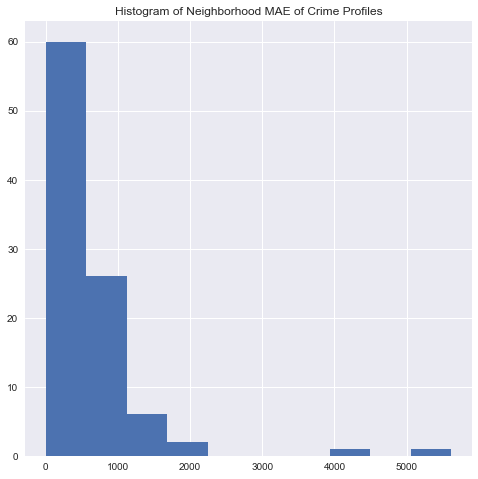

In [22]:
# histogram to see if how the MAEs are distributed across neighborhoods
plt.figure(figsize=(8,8))
plt.hist(mae_list, bins=10)
plt.title("Histogram of Neighborhood MAE of Crime Profiles")
plt.show()

#### Earth Mover's Distance

In [25]:
crime_cols = ["All Crime", "Theft", "Battery", "Narcotics", "Assault", "Homicide", "Deceptive", "Burglary", "Motor", "Trespassing", "Weapons", "Robbery"]
emd_list = within_emd(clustering_grid, 'Neighborhoods', crime_cols)

print("Average within cluster Earth Mover's Distance for neighborhood clusters: " + str(np.mean(mae_list)))

Cluster Size 0 error
Cluster Size 0 error
Average within cluster Earth Mover's Distance for neighborhood clusters: 628.284004064


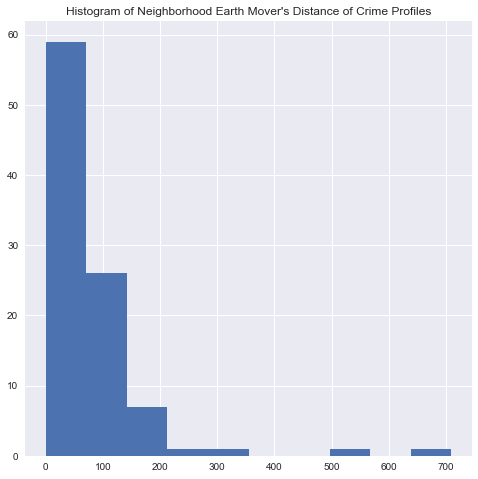

In [26]:
# histogram to see if how the MAEs are distributed across neighborhoods
plt.figure(figsize=(8,8))
plt.hist(emd_list, bins=10)
plt.title("Histogram of Neighborhood Earth Mover's Distance of Crime Profiles")
plt.show()

***
# Baseline 2 - Police Beats
***

#### Mean Absolute Error

In [27]:
clustering_grid.head()

,Unnamed: 0,All Crime,Assault,Battery,Burglary,Deceptive,Homicide,Latitude,Longitude,Motor,Narcotics,Robbery,Theft,Trespassing,Weapons,lat,lon,coord,Neighborhoods,Beats,Cell Towers,waste_basket,library,grave_yard,fire_station,drinking_water,fountain,pub,bicycle_parking,pharmacy,bar,bank,bicycle_rental,bench,cafe,fuel,fast_food,school,restaurant,place_of_worship,parking,Divvy,Bike Rack,Bus Stop,L Stop,Metra
0,0,1074,48,158,29,16,1,42.022458,-87.675421,14,77,28,86,30,15,42.022458,-87.675421,"('-87.675421179', '42.0224578821')",48,31,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,2,0,0
1,1,2600,219,674,97,53,6,42.022458,-87.670930,40,381,73,288,161,55,42.022458,-87.670930,"('-87.6709296026', '42.0224578821')",48,31,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0
2,2,948,72,247,63,40,4,42.022458,-87.666438,18,49,22,191,30,13,42.022458,-87.666438,"('-87.6664380261', '42.0224578821')",48,31,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0
3,3,61,2,14,4,6,0,42.017966,-87.819152,1,0,0,19,4,0,42.017966,-87.819152,"('-87.8191516244', '42.0179663057')",73,33,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,70,4,4,5,14,0,42.017966,-87.814660,0,0,1,21,4,0,42.017966,-87.814660,"('-87.814660048', '42.0179663057')",73,33,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [28]:
crime_cols = ["All Crime", "Theft", "Battery", "Narcotics", "Assault", "Homicide", "Deceptive", "Burglary", "Motor", "Trespassing", "Weapons", "Robbery"]
mae_list = within_mae(clustering_grid, 'Beats', crime_cols)

print("Average within cluster mean absolute error for police beat clusters: " + str(np.mean(mae_list)))
plt.show()

Cluster Size 0 error
Cluster Size 0 error
Cluster Size 0 error
Cluster Size 0 error
Cluster Size 0 error
Average within cluster mean absolute error for police beat clusters: 635.552817084


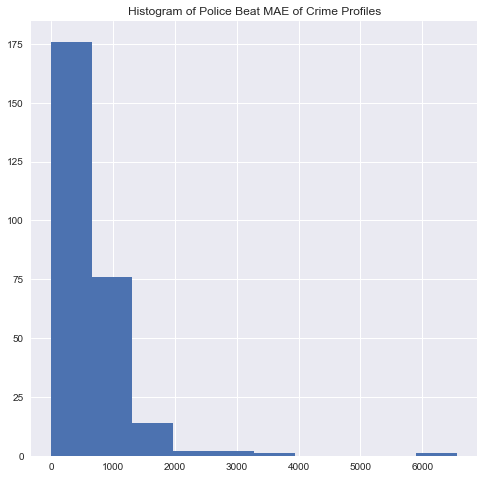

In [29]:
# histogram to see if how the MAEs are distributed across neighborhoods
plt.figure(figsize=(8,8))
plt.hist(mae_list, bins=10)
plt.title("Histogram of Police Beat MAE of Crime Profiles")
plt.show()

#### Earth Mover's Distance

***
# Model 1 - Crime Vector Clustering (Optimal)
***

***
# Model 2 - Transporation Clustering
***

***
# Model 3 - Census and Population Clustering
***